In [2]:
import os
os.environ["HF_HOME"] = "/home/seungwoochoi/data/huggingface/cache"
from tqdm import tqdm
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from FlagEmbedding import BGEM3FlagModel
import numpy as np
import wandb
np.set_printoptions(threshold=np.inf)
device = "cuda"

In [ ]:
class queryDataset(Dataset):
    def __init__(self, queries):
        super().__init__()
        self.queries = queries

    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, index):

        return self.queries[index]

In [ ]:
embedding_model = BGEM3FlagModel('BAAI/bge-m3')

In [2]:
#Load Query Dataset
dataset = load_dataset("microsoft/ms_marco", "v1.1", split ="train", streaming=True)
queries = [x['query'] for x in dataset]  # type: ignore

In [3]:
query_len = 50
query_embeddings = embedding_model.encode(queries)['dense_vecs'][:query_len]
query_embedding = torch.from_numpy(query_embeddings)
query_embedding = query_embedding.to("cuda", dtype=torch.float32)

NameError: name 'embedding_model' is not defined

In [ ]:
passage_len = 100
passage_embedding = np.load("/home/seungwoochoi/data/axis_rag/data/ms_marco_embedding.npy")
passage_embedding = torch.from_numpy(passage_embedding)[:passage_len]
passage_embedding = passage_embedding.to("cuda")
passage_embedding = passage_embedding.to(torch.float32)
print(passage_embedding)

In [ ]:
#Full Embedding으로 계산했을 때 문서 유사도 베스트 순 정렬
full_sim = torch.matmul(passage_embedding, query_embedding.T)
torch.argsort(full_sim[:,0])

In [ ]:
full_ranking = {}
for i in range(query_len):
    full_ranking[i] = torch.argsort(full_sim[:,i])

In [ ]:
def spearman_corr(x: torch.Tensor, y: torch.Tensor) -> float:
    # Get ranks
    def rankdata(t):
        _, indices = torch.sort(t)
        ranks = torch.zeros_like(t, dtype=torch.float32)
        ranks = ranks.to(device)
        # print(ranks)
        ranks[indices] = torch.arange(1, len(t)+1).to(device, dtype=torch.float32)
        return ranks

    x_rank = rankdata(x)
    y_rank = rankdata(y)
    # print(x_rank)
    # print(y_rank)
    # Compute Pearson correlation on the ranks
    x_mean = x_rank.mean()
    y_mean = y_rank.mean()

    cov = ((x_rank - x_mean) * (y_rank - y_mean)).mean()
    std_x = x_rank.std(unbiased=False)
    std_y = y_rank.std(unbiased=False)
    # print(cov / (std_x * std_y))
    return cov / (std_x * std_y) #type:ignore

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
passage_embedding = passage_embedding.to(device)
full_sim = full_sim.to(device)

list_sorted_axes = []

for i, q_em in tqdm(enumerate(query_embeddings)):
    q_em_tensor = torch.from_numpy(q_em).float().to(device)
    sorted_axes = []
    axes = list(range(1024))

    while len(axes) > 0:
        print(len(axes))
        tmp_axes = sorted_axes[:]
        
        # [B] Vectorised candidate axis evaluation
        candidate_axes = torch.tensor([tmp_axes + [a] for a in axes], device=device)  # shape [num_axes, len_axes] #type:ignore
        # print(candidate_axes)
        
        # Create batch of passage projections: [num_axes, num_passages, len_axes]
        passage_batch = passage_embedding[:, candidate_axes.T].permute(2, 0, 1)  # [num_axes, N, len_axes]
        # print(passage_batch)

        # Create batch of query projections: [num_axes, len_axes]
        q_batch = q_em_tensor[candidate_axes]  # [num_axes, len_axes]
        # print(q_batch)

        # Compute scores: [num_axes, N]
        scores = torch.einsum('ank,ak->an', passage_batch, q_batch)
        # print(scores)

        # Compute Spearman for each axis candidate
        target = full_sim[:, i]
        # print(target)

        spearman_scores = torch.stack([
            spearman_corr(scores[j], target) for j in range(len(axes))
        ]) #type:ignore

        # Pick best axis
        best_idx = torch.argmax(spearman_scores).item()
        best_axis = axes[best_idx] #type:ignore

        sorted_axes.append(best_axis)
        axes.remove(best_axis)

    list_sorted_axes.append(sorted_axes)

In [ ]:

import pandas as pd

# list_sorted_axes is a list of lists, each inner list is axis order for one query
df = pd.DataFrame(list_sorted_axes)

# Save to CSV
df.to_csv("/home/seungwoochoi/data/axis_rag/sorted_axes.csv", index=False, header=False)

In [ ]:
#greedy axis choosing
from tqdm import tqdm
list_sorted_axes = []
for i, q_em in tqdm(enumerate(query_embeddings)):
    q_em_tensor = torch.from_numpy(q_em)
    sorted_axes = []
    axes = list(range(1024))
    while len(axes)>0:
        print(len(axes))
        tmp_axes = sorted_axes[:]
        best_axis = axes[0]
        
        best_score = spearman_corr(torch.matmul(passage_embedding[:,[*tmp_axes,axes[0]]],q_em_tensor[[*tmp_axes,axes[0]]]), full_sim[:,i]) # type: ignore
        for axis in axes:
            score = spearman_corr(torch.matmul(passage_embedding[:,[*tmp_axes,axis]],q_em_tensor[[*tmp_axes,axis]]), full_sim[:,i]) #type: ignore 
            if(score > best_score): 
                best_axis = axis
                best_score = score
        
        sorted_axes.append(best_axis)
        axes.remove(best_axis)
    
    list_sorted_axes.append(list_sorted_axes)




In [ ]:
from itertools import combinations


In [ ]:
a = [1,2,3]
[a]

In [ ]:
with open("/home/seungwoochoi/data/axis_rag/sorted_axes.csv", 'r') as f:
    lines = f.readlines()
lines = [x.split(',')[:50] for x in lines]

from collections import Counter

cnt = Counter()

for line in lines:
    for axis in line:
        cnt[axis] += 1

cnt


In [ ]:
import matplotlib.pyplot as plt

# Example data: each sublist is a line
with open("/home/seungwoochoi/data/axis_rag/corr.csv", 'r') as f:
    data = f.readlines()[:20]
data = [x.split(',') for x in data]
for i, x in enumerate(data):
    data[i] = [float(y) for y in x]

with open("/home/seungwoochoi/data/axis_rag/random_corr.csv", 'r') as f:
    random_data = f.readlines()[:20]
random_data = [x.split(',') for x in random_data]
for i, x in enumerate(random_data):
    print(x)
    random_data[i] = [float(y) for y in x]


# print(data)

# Plot each list
for i, series in enumerate(data):
    cutoff = 0
    for j, n in enumerate(series):
        if(n >= 0.9):
            cutoff = j
            break
    plt.plot(series, label=f'Query {i+1} (greedy) | 0.9 cutoff = {cutoff}', linewidth=1)


for i, series in enumerate(random_data):
    cutoff = 0
    for j, n in enumerate(series):
        if(n >= 0.9):
            cutoff = j
            break
    plt.plot(series, label=f'Query {i+1} (random) | 0.9 cutoff = {cutoff}', linestyle='dashed', linewidth=1)

plt.xlabel('# of Axis from Embedidng')
plt.ylabel('Spearman Corr. with Full Embedding Ranking')
# plt.title('Line Chart of List of Lists')
plt.yticks([i * 0.1 for i in range(0, 11)], fontsize=8)
plt.xticks([i * 100 for i in range(11)], fontsize=8)
plt.gcf().set_size_inches(10, 8)
plt.legend(fontsize=9, bbox_to_anchor=(1, 1), loc='upper left')
# plt.grid(True, axis = 'y')
# plt.legend(fontsize=8)
plt.show()

# Hadamard Product Visualization

In [3]:
from FlagEmbedding import BGEM3FlagModel
embedding_model = BGEM3FlagModel('BAAI/bge-m3')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
import numpy as np
from datasets import load_dataset

#Load Query Dataset
dataset = load_dataset("microsoft/ms_marco", "v1.1", split ="train", streaming=True)
queries = [x['query'] for x in dataset]  # type: ignore
queries = queries[:100]
query_embeddings = embedding_model.encode(queries)['dense_vecs']

passage_len = 50
passage_embeddings = np.load("/home/seungwoochoi/data/axis_rag/data/ms_marco_embedding.npy")
passage_embeddings = passage_embeddings[:passage_len]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [81]:
queries[30]

'how long will i be in hospital after a gallbladder surgery last'

In [4]:
passage_embeddings

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

sim_scores = np.matmul(passage_embeddings, query_embeddings.T)
outer_products = np.einsum('ib, jb -> ijb', passage_embeddings, query_embeddings, optimize=True)


In [23]:


# --- 모든 쿼리의 컬럼 평균 0으로 센터링한 버전 생성 ---
# 원본 복사
outer_centered = outer_products.copy()

# 각 column(마지막 축) 평균을 passage 축(axis=0) 기준으로 뺌
# outer_products shape: (num_passages, num_queries, dims)
# col_meaThe line `n_all = outer_centered.mean(axis=0, keepdims=True)` is calculating the mean of all columns across all passages for each query in the `outer_centered` array.
n_all = outer_centered.mean(axis=0, keepdims=True)  # (1, num_queries, dims)
# outer_centered -= col_mean_all

# --- 전체 데이터에서 max_abs 계산 ---
# global_max_abs = np.max(np.abs(outer_centered))
# (아웃라이어 영향 줄이고 싶으면)
global_max_abs = np.percentile(np.abs(outer_centered), 99)


for query_idx in range(query_embeddings.shape[0]):
    # sim_scores 기준으로 passage 인덱스 정렬 (오름차순)
    sim_score = np.matmul(passage_embeddings, query_embeddings[query_idx,:])
    # print(sim_score)

    argsort_result = np.argsort(sim_scores[:, query_idx], axis=0)  # shape: (num_passages,)

    # # 벡터화: 행 재배열 (loop 없이)
    mat_for_visualization = passage_embeddings[argsort_result,:] * query_embeddings[query_idx,:]
    # print(np.sum(mat_for_visualization, axis=1))
    
    # print(mat_for_visualization.shape)


    # # --- 컬럼별 평균 0으로 센터링 ---
    col_mean = mat_for_visualization.mean(axis=0, keepdims=True)           # (1, dims)
    mat_for_visualization = mat_for_visualization - col_mean

    # # (옵션) 컬럼별 스케일까지 맞추고 싶으면 주석 해제 (z-score)
    # # col_std = mat_for_visualization.std(axis=0, keepdims=True)
    # # mat_for_visualization = mat_for_visualization / np.where(col_std == 0, 1, col_std)

    # 색상 스케일을 양/음 대칭으로
    max_abs = np.max(np.abs(mat_for_visualization))
    # (아웃라이어가 심하면 아래처럼 퍼센타일 기반 권장)
    max_abs = np.percentile(np.abs(mat_for_visualization), 99)

    plt.figure(figsize=(24, 6))
    im = plt.imshow(
        mat_for_visualization,
        cmap='bwr',                 # 음수=파랑, 양수=빨강
        aspect='auto',
        vmin=-max_abs,
        vmax= max_abs
    )

    plt.colorbar(im, label='Value (column-centered)')
    plt.title(f'Hadamard Product Visualizaion | Query {query_idx}')
    plt.xlabel('Dimension')
    plt.ylabel('Passages')
    plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/{query_idx}.png")
    plt.close()
    # # plt.show()

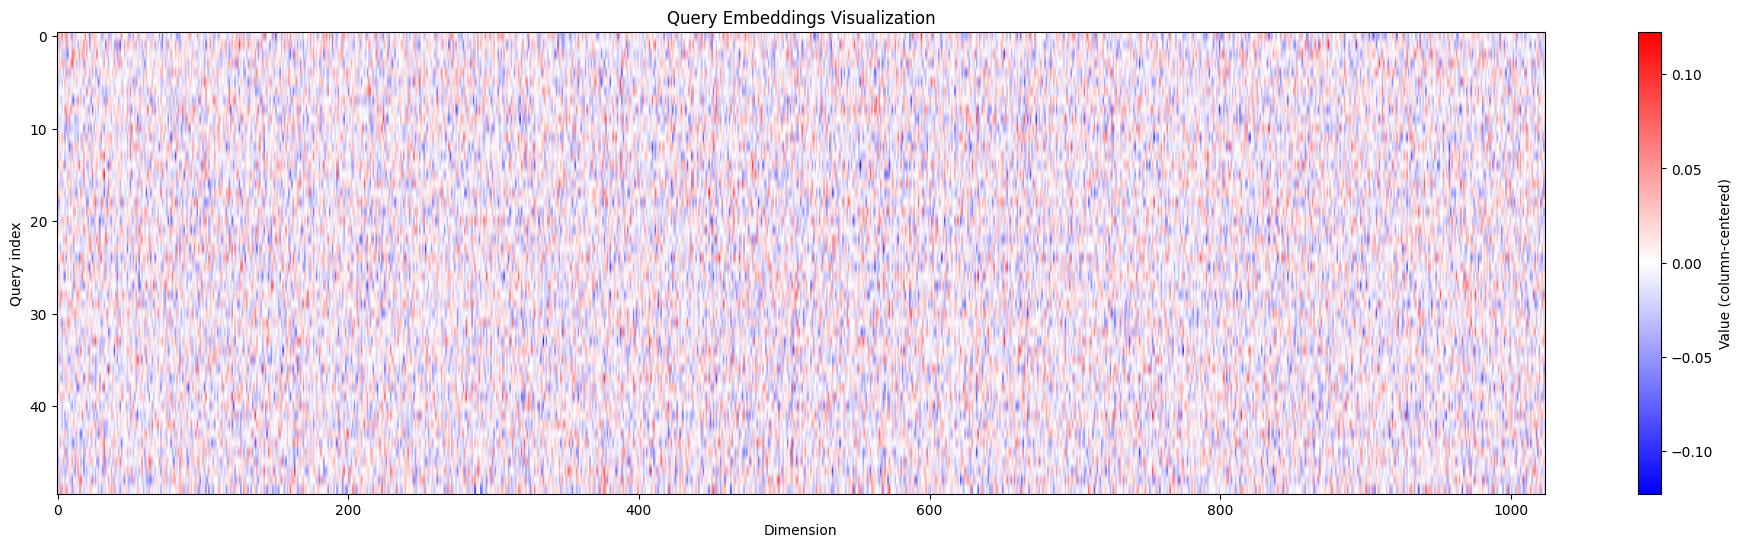

In [22]:
import matplotlib.pyplot as plt
mat_for_visualization = query_embeddings[:50,:]

# --- 컬럼별 평균 0으로 센터링 ---
col_mean = mat_for_visualization.mean(axis=0, keepdims=True)           # (1, dims)
mat_for_visualization = mat_for_visualization - col_mean

# (옵션) 컬럼별 스케일까지 맞추고 싶으면 주석 해제 (z-score)
# col_std = mat_for_visualization.std(axis=0, keepdims=True)
# mat_for_visualization = mat_for_visualization / np.where(col_std == 0, 1, col_std)

# 색상 스케일을 양/음 대칭으로
max_abs = np.max(np.abs(mat_for_visualization))
# (아웃라이어가 심하면 아래처럼 퍼센타일 기반 권장)
# max_abs = np.percentile(np.abs(mat_for_visualization), 99)

plt.figure(figsize=(24, 6))
im = plt.imshow(
    mat_for_visualization,
    cmap='bwr',                 # 음수=파랑, 양수=빨강
    aspect='auto',
    vmin=-max_abs,
    vmax= max_abs
)

plt.colorbar(im, label='Value (column-centered)')
plt.title(f'Query Embeddings Visualization')
plt.xlabel('Dimension')
plt.ylabel('Query index')
plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/Query_embedding.png")
# plt.show()

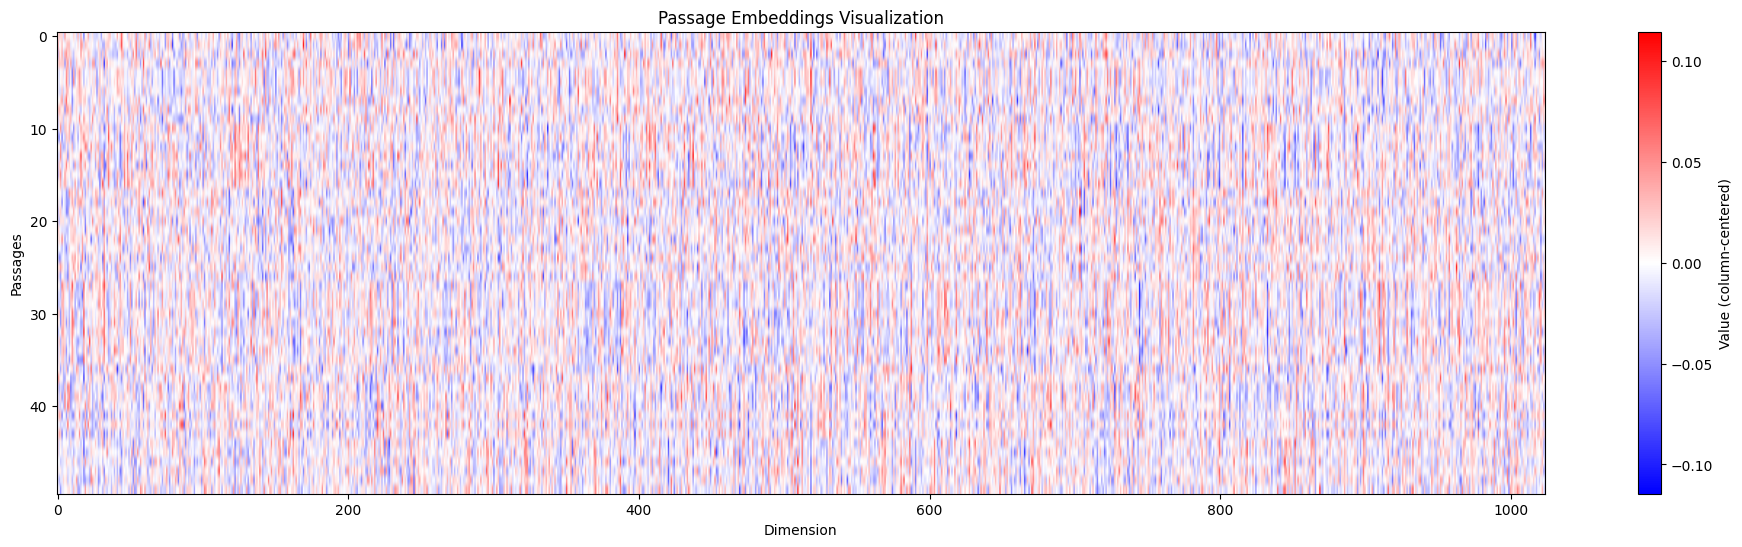

In [ ]:
import matplotlib.pyplot as plt
# for passage_idx in range(passage_embeddings.shape[0]):
# 벡터화: 행 재배열 (loop 없이)
mat_for_visualization = passage_embeddings[:,:]

# --- 컬럼별 평균 0으로 센터링 ---
col_mean = mat_for_visualization.mean(axis=0, keepdims=True)           # (1, dims)
mat_for_visualization = mat_for_visualization - col_mean

# (옵션) 컬럼별 스케일까지 맞추고 싶으면 주석 해제 (z-score)
# col_std = mat_for_visualization.std(axis=0, keepdims=True)
# mat_for_visualization = mat_for_visualization / np.where(col_std == 0, 1, col_std)

# 색상 스케일을 양/음 대칭으로
max_abs = np.max(np.abs(mat_for_visualization))
# (아웃라이어가 심하면 아래처럼 퍼센타일 기반 권장)
# max_abs = np.percentile(np.abs(mat_for_visualization), 99)

plt.figure(figsize=(24, 6))
im = plt.imshow(
    mat_for_visualization,
    cmap='bwr',                 # 음수=파랑, 양수=빨강
    aspect='auto',
    vmin=-max_abs,
    vmax= max_abs
)

plt.colorbar(im, label='Value (column-centered)')
plt.title(f'Passage Embeddings Visualization')
plt.xlabel('Dimension')
plt.ylabel('Passages')
plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/Passage_embedding.png")
# plt.show()

In [1]:
import os
os.environ["HF_HOME"] = "/home/seungwoochoi/data/huggingface/cache"
import numpy as np
from datasets import load_dataset
from FlagEmbedding import BGEM3FlagModel
marco_data = load_dataset("microsoft/ms_marco", "v1.1", split ="train", streaming=True)

passages = []
for data in marco_data:
    passages += data['passages']['passage_text']


In [ ]:
np.set_printoptions(threshold=np.inf)

In [4]:
print(passages[30])
print(passages[31])
print(passages[32])
print(passages[33])
print(passages[34])
print(passages[35])



Granite shower tile is available at an average of $3.49 per square foot to $6.99 per square foot. Polished stone wall tile comes in many choices, including pebble stone that costs about $10 per square foot and $12 per square foot for a smooth surface polished stone tile.
1 Higher-end tile such as granite or marble is going to cost more than a standard ceramic tile. 2  On average, plan on spending anywhere from $2,500 to as much as $5,000 or more for a standard 3′ x 5′ shower. 3  Showers can widely vary in size, but most of the time the cost will be within this price range.
Our free calculator uses recent, trusted data to estimate costs for your Bathroom Floor Tile Installation project. For a basic 120 square feet project in zip code 47474, the benchmark cost to Install Bathroom Floor Tile ranges between $9.53 - $13.80 per square foot* .
The cost for a typical small bathroom remodel will range from about $4,000 to $12,000 with the average cost being about $8,000. Let’s look at how the c

In [9]:
test_queries = [
    "In animals, somatic cells are produced by what process and gametic cells are produced by what process?",
    "Which type of cell division produces somatic cells in animals, and which produces gametic cells?",
    "In animals, what produces somatic cells and what produces gametes?",
    "Somatic cells in animals are formed by which process, and gametes by which?",
    "Name the processes that produce somatic and gametic cells in animals.",
    "What is the process for producing somatic cells in animals, and what is the process for producing gametes?",
    "In animals, which process forms body cells and which forms reproductive cells?",
    "How are somatic cells made in animals, and how are gametes made?",
    "What kind of cell division generates somatic cells and which one generates gametic cells in animals?",
    "In animals, body cells are created by which process and sex cells by which?"
]
test_embeddings = embedding_model.encode(test_queries)['dense_vecs']
test_embeddings

array([[-5.1117e-02, -3.1494e-02, -4.8309e-02, -7.8278e-03, -6.7978e-03,
        -5.8685e-02, -6.1157e-02,  5.2582e-02, -2.7573e-02, -3.1189e-02,
        -2.3560e-02,  1.8753e-02, -1.8845e-02, -2.1210e-02,  6.3820e-03,
        -2.4246e-02,  1.0666e-02, -2.2659e-02, -4.1595e-02, -3.5034e-02,
         8.0032e-03, -6.4636e-02,  2.2339e-02, -4.1351e-02,  2.0981e-02,
        -1.5961e-02, -7.8049e-03,  5.6419e-03,  1.7258e-02, -2.7252e-02,
         3.1021e-02, -2.9507e-03, -5.1697e-02, -2.6840e-02, -4.0375e-02,
        -4.0680e-02, -9.6655e-04, -2.0416e-02, -5.4169e-02,  2.5711e-02,
         4.8141e-03, -3.6621e-02,  4.2145e-02, -2.4216e-02, -2.7771e-02,
        -2.1683e-02, -1.6907e-02, -4.7302e-02,  6.2990e-04,  2.7924e-02,
        -4.5868e-02,  2.9205e-02,  4.4746e-03, -7.4425e-03,  5.6793e-02,
         6.5002e-02, -1.4908e-02, -3.3905e-02, -5.7251e-02,  1.7227e-02,
        -2.4414e-02, -9.5272e-04,  2.5314e-02,  1.5053e-02,  4.7943e-02,
         7.8552e-02,  2.6764e-02,  1.2810e-02, -7.3

In [10]:
import numpy as np

# def hadamard_product(vectors, eps=1e-12):
#     X = np.array(vectors)
#     col_mean = X.mean(axis=0, keepdims=True)
#     X = X - col_mean
#     print(X)
#     mag = np.abs(X) + eps

#     # 모든 벡터가 같은 부호인지 체크
#     all_same_pos = np.all(X > 0, axis=0)
#     all_same_neg = np.all(X < 0, axis=0)

#     # 방향 부호
#     dir_sign = np.where(all_same_pos, 1.0,
#                         np.where(all_same_neg, -1.0, 0.0))

#     # print(dir_sign)
#     # 크기는 로그도메인에서 합산
#     # out = np.exp(np.log(mag).sum(axis=0)) * dir_sign

#     out = np.exp(np.log(mag).sum(axis=0))
#     # print(out)
#     # L2 정규화
#     out /= (np.linalg.norm(out) + eps)
#     out = out+col_mean[0,:]
#     out /= (np.linalg.norm(out) + eps)
    
#     # print(np.dot(out,out))
#     return out


def hadamard_product(vectors, eps=1e-12):
    X = np.array(vectors)

    # 모든 벡터가 같은 부호인지 체크
    all_same_pos = np.all(X > 0, axis=0)
    all_same_neg = np.all(X < 0, axis=0)

    # 방향 부호
    dir_sign = np.where(all_same_pos, 1.0,
                        np.where(all_same_neg, -1.0, 0.0))

    col_mean = X.mean(axis=0, keepdims=True)
    X = X - col_mean

    out = X[0].astype(float)

    for v in X[1:]:
        out = out * v                    # Hadamard 곱
        out /= (np.linalg.norm(out) + eps)  # 매 스텝 L2 정규화

    out = out + col_mean
    out /= (np.linalg.norm(out) + eps)
    out = np.abs(out)
    out = out * dir_sign
    return out[0,:]
    


In [11]:
import matplotlib.pyplot as plt
import numpy as np


test_embeddings_x = hadamard_product(test_embeddings)
print(test_embeddings_x)

[-3.99979204e-02  0.00000000e+00 -3.87133127e-02  0.00000000e+00
  0.00000000e+00 -6.57661877e-02 -3.84887318e-02  2.54613880e-02
 -1.62052436e-02 -2.76925595e-02 -1.59591078e-02  0.00000000e+00
 -1.87063353e-02  0.00000000e+00  0.00000000e+00 -2.66513105e-02
  0.00000000e+00 -2.06046418e-02 -3.67634025e-02 -3.03299750e-02
  0.00000000e+00 -4.53843040e-02  0.00000000e+00 -1.35585342e-01
  1.54303050e-02  0.00000000e+00 -1.18065070e-02  0.00000000e+00
  0.00000000e+00 -1.31616098e-02  2.07066506e-02  0.00000000e+00
 -3.53815069e-02 -4.84797737e-03  0.00000000e+00 -3.59614620e-02
  0.00000000e+00 -1.59021419e-02 -3.75524344e-02  2.48506935e-02
  0.00000000e+00 -1.77158364e-02  2.76243054e-02 -1.74774046e-02
 -2.14678915e-02 -1.78026169e-02  0.00000000e+00 -3.45530842e-02
  0.00000000e+00  0.00000000e+00 -3.56188999e-02  2.25132863e-02
  0.00000000e+00  0.00000000e+00  3.81424232e-02  4.21425117e-02
  0.00000000e+00 -1.84184016e-02 -5.21208488e-02  0.00000000e+00
  0.00000000e+00  0.00000

(1024,)
(10, 1024)
(11, 1024)


Text(0, 0.5, 'Queries')

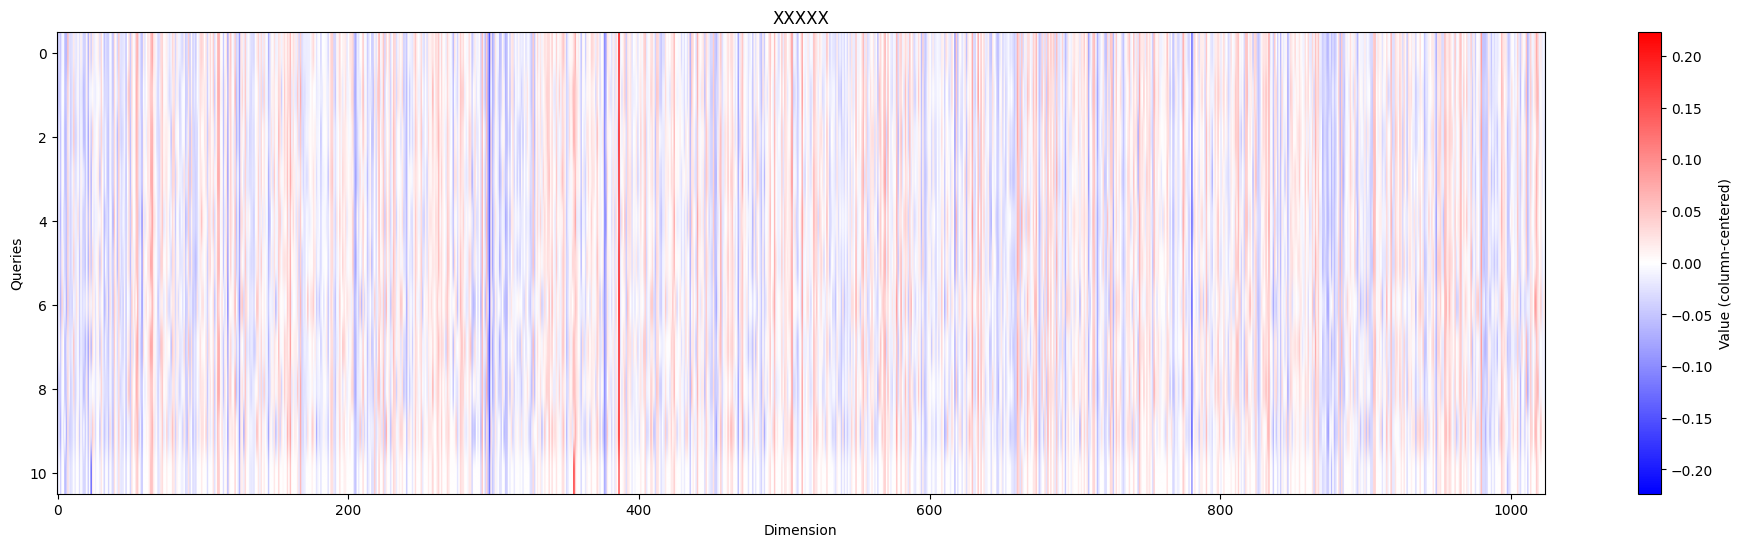

In [13]:

print(test_embeddings_x.shape)
print(test_embeddings.shape)


mat_for_visualization = np.concatenate((test_embeddings, test_embeddings_x[None,:]), axis=0)

print(mat_for_visualization.shape)

# --- 컬럼별 평균 0으로 센터링 ---
# col_mean = mat_for_visualization.mean(axis=0, keepdims=True)           # (1, dims)
# mat_for_visualization = mat_for_visualization - col_mean

# (옵션) 컬럼별 스케일까지 맞추고 싶으면 주석 해제 (z-score)
# col_std = mat_for_visualization.std(axis=0, keepdims=True)
# mat_for_visualization = mat_for_visualization / np.where(col_std == 0, 1, col_std)

# 색상 스케일을 양/음 대칭으로
max_abs = np.max(np.abs(mat_for_visualization))
# (아웃라이어가 심하면 아래처럼 퍼센타일 기반 권장)
# max_abs = np.percentile(np.abs(mat_for_visualization), 99)

plt.figure(figsize=(24, 6))
im = plt.imshow(
    mat_for_visualization,
    cmap='bwr',                 # 음수=파랑, 양수=빨강
    aspect='auto',
    vmin=-max_abs,
    vmax= max_abs
)

plt.colorbar(im, label='Value (column-centered)')
plt.title(f'XXXXX')
plt.xlabel('Dimension')
plt.ylabel('Queries')
# plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/{query_idx}.png")
# plt.show()

In [15]:
test_score = np.matmul(passage_embeddings, mat_for_visualization.T)


In [16]:
print(np.argsort(test_score[:,0])[-30:])
print(np.argsort(test_score[:,-1])[-30:])

[100340 545779 639275 117205 641155 531282 673113 360730  31709     91
 639281 204808 597342     90 292010 347578 639277 557191 543550 639279
  14848 597340 241750     92 628339 204813 639278     89 184443     95]
[545782 117202 673113 673115 597342 543551 290147     96 597344 129766
 673114 290146     92 289261 269917 628339 557191 639277 639278  14848
 347578 204808 292010 184443 241750 597340     89 543550 204813     95]


In [17]:
import numpy as np
from scipy.stats import spearmanr

# Spearman correlation
rho, p_value = spearmanr(np.argsort(test_score[:,0]), np.argsort(test_score[:,-1]))

print("Spearman rho:", rho)
print("p-value:", p_value)

Spearman rho: 0.001055581961588436
p-value: 0.3853867957762974


In [21]:
print(passages[91])
print(passages[129766])

In humans, n = 23. Gametes contain half the chromosomes contained in normal diploid cells of the body, which are also known as somatic cells. Haploid gametes are produced during meiosis, which is a type of cell division that reduces the number of chromosomes in a parent diploid cell by half. The term haploid can also refer to the number of chromosomes in egg or sperm cells, which are also called gametes. In humans, gametes are haploid cells that contain 23 chromosomes, each of which a one of a chromosome pair that exists in diplod cells.
The gametes (sperm and unfertilized egg, or ovum). In humans, body cells are diploid. To form gametes, specialized cells in the gonads (primary spermatocytes in males, and primary oocytes in females) must go through meiosis. Strictly, there are more than two types of cell that are haploid. The cells formed by meiosis I are haploid, and these are (in males) secondary spermatocytes, and (in females) secondary oocytes. These divide (meiosis II) to form mo